# Worksheet 10: A/B Testing and principled peeking

## Learning Objectives 

After completing this week's worksheet and tutorial work, you will be able to:

1. Discuss why the methods learned in past courses are not sufficient to answer the more complex research problems being posed in this course (in particular stopping an A/B test early).
2. Explain sequential testing and principled peeking and how it can be used for early stopping of an experiment (e.g., A/B testing).
3. Write a computer script to perform A/B testing optimization with and without using principled peeking.
4. Discuss the tradeoff between stopping earlier and certainty of significance, and thereal world implications (e.g., what does the FDA require for early stopping of clinical trials versus Facebook ads optimization?).
5. List other questions related to A/B testing optimization that may be relevant in a real data application (e.g., what features cause a Facebook ad to perform best?)

## Loading packages

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(infer)
library(broom)
library(gsDesign)

source("tests_worksheet_10.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




# Part I (Tuesday)

## 1. A/B Testing Optimization

**A/B testing** refers to an experiment, in which users are randomly assigned to one of two variations of a product or service: control (A) and variation (B) to see if variation B should be used for improvement.

> A/B testing became very popular in the context of updating and improving websites. However, they can be used in many other contexts to monitor and update products and/or services.

A key factor in A/B testing is deciding which statistical tool will be used to analyzed the data collected. For example, a classical $t$-test can be used to compare differences of population means. In this worksheet we will review some fundamental concept of hypothesis testing in the context of A/B testing problems.

#### For the questions in this section, suppose that you are designing an A/B testing to decide if a new website used to collect donations for a political campaign results in an increment on the donation sizes. 

**Question 1.0**
<br>{points: 1}

Before performing any analysis of the collected data, it is important to decide the significance level of the test, a.k.a **Type I error rate**. This quantity is interpreted as:

**A.** the probability of finding a significant difference between the donation sizes collected from two variations of the website, when the new website indeed attracts, on average, larger donations.

**B.** the probability of *not* finding a significant difference between the donation sizes collected from two variations of the website, when the new website indeed attracts, on average, larger donations.

**C.** the probability of finding a significant difference between the donation sizes collected from two variations of the website, when the mean of the size of the donations of both websites are equal.

**D.** the probability that the new website indeed attracts larger donations.

*Assign your answer to an object called `answer1.0`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes.*

In [2]:
answer1.0 <-  "C"

# your code here
# No Answer - remove if you provide an answer

In [3]:
test_1.0()

Test passed 🎊
Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 1.1**
<br>{points: 1}

The designers of the experiment also need to decide how large the experiment will be since there are large costs (including opportunity costs) related to the experiment. 

Thus, for the statistical test planned, they decide to conduct a **power analysis** to:

**A.** estimate the minimum sample size required, given a desired significance level, expected difference in mean donations, and statistical power.

**B.** maximize the probability of finding a significant difference between the donation sizes collected from two variations of the website.

**C.** minimize the probability of not finding a significant difference between the donation sizes collected from two variations of the website.


*Assign your answer to an object called `answer1.1`. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*

In [4]:
 answer1.1 <- "A"

# your code here# No Answer - remove if you provide an answer

In [5]:
test_1.1()

Test passed 🎉
Test passed 🥇
Test passed 🌈
[1] "Success!"


**Question 1.2**
<br>{points: 1}

After deciding on the sample size required and *randomly* assigning visitors to each variation of the website, the company will start analyzing the size of the donations made by visitors. 

Since the sample size planned is large enough, the analysts will conduct a classical hypothesis test and compute $p$-values and confidence intervals based on results from the CLT.

Considering the opportunity costs involved in this experiment, the analysts are going to monitor the size of the donations closely and stop the experiment earlier if they find (using a standard 2-samples $t$-test) that the new website attracts higher donations. 

However, computing (raw) $p$-values before collecting *all* the data in the experiment and stopping the experiment based on preliminary findings can result in a false discovery and increments in the costs associated with an unnecessary switch to new website.

**True or False??**

**Note**: "raw" here means non-adjusted $p$-values. 

*Assign your answer to an object called answer1.2 Your answer should be either "true" or "false", surrounded by quotes.*

In [6]:
answer1.2 <- "true"

# your code here
# No Answer - remove if you provide an answer

In [7]:
test_1.2()

Test passed 😀
Test passed 🌈
Test passed 🎉
[1] "Success!"


## 2. Early Stopping in A/B Testing

In this section you will analyze data from an A/A experiment to examine the problem of **early stopping**.

> ***Can we stop or re-design the experiment earlier if we have supporting evidence to do so??***

**Note**: in data simulated from an A/A testing we know that $H_0$ is true (i.e., there is no effect)

  - we can think of a scenario where both groups are exposed to the same website
  
  - in this scenario, we know that claiming a significant result is a false discovery
  
Although this procedure seems artificial, it is a widely used technique to test experiments and platforms. Since you are in full control of the data generating process, you can repeat the experiment *many* times to estimate error rates associated with your experiment.

![img](img/aa-Obama.png)
<font color=grey>Figure by [R. Lourenzutti](https://lourenzutti.github.io) </font>

Each simulated dataset will be analyzed according to the following steps:

- run a balanced experiment with a *pre-set* sample size of $n$ visitors per variation 

- **sequentially collect** the data in batches of visitors per group

- **sequentially analyze** the data using two-sample $t$-tests

- **sequentially compute and monitor** (raw) $p$-values 

- **stop** the experiment **once a significant result** is found 

#### Simulation function

We have prepared a function for you that: 

- generates two samples, each of size `n`, from two (known) Normal distribution, the control and the variation. Note that this can only be done in a simulation study. In a real data analysis we collect data from an *unknown* distribution

- analyzes the data in an incremental way by `sample_increase_step` until all `n` samples in each treatment group are analyzed. For example: compares donations by batches of visitors of each website variation  

- returns the $t$-statistic and $p$-value (computed by a two-sample $t$-test) for every set of collected data. For example: $p$-values to assess the difference in means of the size of donations made by visitors of each website as batches of data are collected

For example, if `sample_increase_step` is 20, and `n=500`, the function will:
1. draw samples of 500 experimental units from the control distribution and 500 from the variation distribution;
1. subset the first 20 experimental units from each sample;
2. perform the two-sample $t$-test and return the associated $t$-statistic and $p$-value;
3. add 20 more experimental units to each group 
4. perform the two-sample $t$-test (now based on 40 experimental units per group) and return the associated $t$-statistic and $p$-value  
5. add another 20 experimental units to each group 
6. perform the two-sample $t$-test (now based on 60 experimental units per group) and return the associated $t$-statistic and $p$-value 
$$
\vdots\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad
$$
and so on, until the total sample size in each group is 500 (as originally planned).

The function returns a tibble that has three columns:

- `inc_sample_size`: the sample size of the set of data analyzed 
- `statistic`: $t$-statistic calculated by the `t.test()` function
- `p_value`: $p$-value calculated by the `t.test()` function

In [8]:
# Two-sample t-test with tracking sequential statistic and p-values by incremental sample sizes until getting to n in each group.

# @param n (numeric): Initially planned sample size for each group (for simplicity, n needs to be a multiple of sample_increase_step).
# @param d_0 (numeric): effect size.
# @param mean_current (numeric): Population mean for control variation.
# @param sd_current (numeric): Population standard deviation for current variation.
# @param sd_new (numeric): Population standard deviation for new variation.
# @param sample_increase_step (numeric): Sample size increment.

# @return p.value.df: A tibble that has 3 columns:
# inc_sample_size, statistic, and p_value 

incremental_t_test <- function(n, d_0, mean_current, sd_current, sd_new, sample_increase_step) {
  sample_current <- rnorm(n, mean = mean_current, sd = sd_current)
  sample_new <- rnorm(n, mean = mean_current + d_0, sd = sd_new)

  p.value.df <- tibble(
    inc_sample_size = rep(0, n / sample_increase_step),
    statistic = rep(0, n / sample_increase_step),
    p_value = rep(0, n / sample_increase_step)
  )

  current_sample_size <- sample_increase_step
  
  for (i in 1:nrow(p.value.df))
  {
    t_test_results <- t.test(sample_new[1:current_sample_size], sample_current[1:current_sample_size],
      var.equal = TRUE,
      alternative = "greater"                      
    )
    p.value.df[i, "statistic"] <- as_tibble(t_test_results$statistic)
    p.value.df[i, "p_value"] <- as_tibble(t_test_results$p.value)
    p.value.df[i, "inc_sample_size"] <- current_sample_size
    current_sample_size <- current_sample_size + sample_increase_step
  }

  return(p.value.df)
}

#### For the questions in this section, suppose that before running an A/B testing to compare the dontion sizes from 2 variations of websites in a political campaign, you design an A/A testing to examine the early stopping problem.

**Question 2.0**
<br>{points: 1}

In a simulation study, we know the true population distributions! The function given to you to simulate the data assumes:

**A.** the sample distributions are $\mathcal{N}(0,1)$

**B.** the population distribution of the donation sizes of visitors of the current website is $\mathcal{N}(\mu_0,\sigma_0^2)$, where $\mu_0$ = mean_current and $\sigma_0$ = sd_current

**C.** the sample distribution of the donation sizes of visitors of the current website is $\mathcal{N}(\mu_0,\sigma_0^2)$, where $\mu_0$ = mean_current and $\sigma_0$ = sd_current

*Assign your answer to an object called `answer2.0`. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*

In [12]:
answer2.0 <- "B"

# your code here
 # No Answer - remove if you provide an answer

In [13]:
test_2.0()

Test passed 🥇
Test passed 🥳
Test passed 🌈
[1] "Success!"


**Question 2.1**
<br>{points: 1}

Simulate data for an A/A testing from populations with the same expected size of the donations (e.g., assuming all visitors are exposed to the same website). 

Suppose that the compaign organizers want to analyze the data in batches of 50 visitors per group until a total of $n = 1000$ visitors have watched each website.

Use the `incremental_t_test` function to conduct the company's experiment. 

*Save the result in an object called `answer2.1`. Your answer should be a tibble with three columns: `inc_sample_size`, `statistic` and `p_value`.*

In [14]:
set.seed(301) # do not change this.

answer2.1 <- 
    incremental_t_test(n = 1000, d_0 = 0, sample_increase_step = 50, mean_current = 200, sd_current = 50, sd_new = 50)

# your code here
# No Answer - remove if you provide an answer

answer2.1

inc_sample_size,statistic,p_value
<dbl>,<dbl>,<dbl>
50,0.5193916601,0.30232937
100,1.7897758994,0.03750907
150,0.2302835574,0.40901472
200,-0.0332989395,0.51327355
250,-0.1749465439,0.56940363
300,0.4222830690,0.33648510
350,0.1120625708,0.45540301
400,-0.3826409831,0.64895606
450,-0.4858319932,0.68639760


In [15]:
test_2.1()

Test passed 😸
Test passed 🥇
Test passed 🎊
[1] "Success!"


**Question 2.2**
<br>{points: 1}

Using the data stored in `answer2.1`, plot the $p$-value sequence as a **line** with the incremental sample size on the $x$-axis and $p$-value on the $y$-axis. Add a dashed horizontal red line that indicates a threshold of the significance level $\alpha = 0.05$. The `ggplot()` object's name will be `sequential_pvalue`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

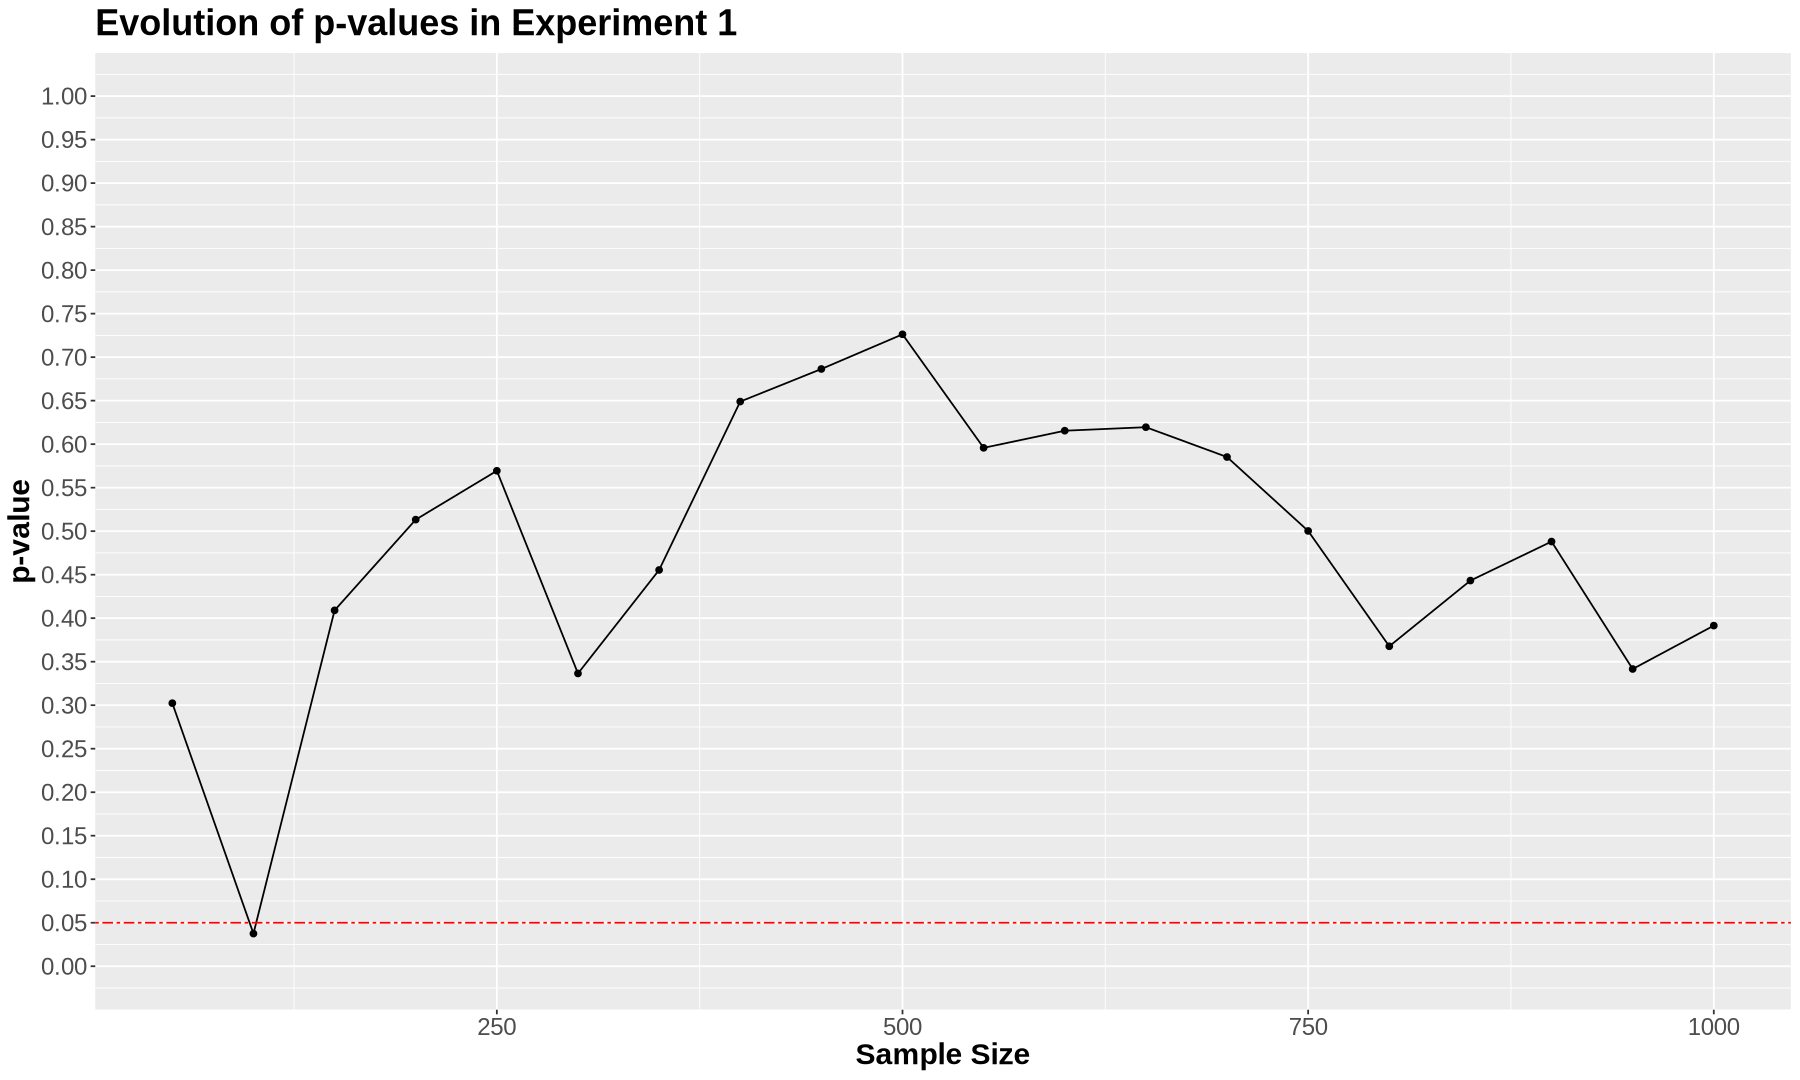

In [16]:
options(repr.plot.width = 15, repr.plot.height = 9) # Adjust these numbers so the plot looks good in your desktop.

 sequential_pvalue <- 
   answer2.1 %>%
   ggplot() +
   geom_line(aes(x = inc_sample_size, y = p_value)) +
   theme(
     text = element_text(size = 18),
     plot.title = element_text(face = "bold"),
     axis.title = element_text(face = "bold")
   ) +
   geom_point(aes(x = inc_sample_size, y = p_value)) +
   ggtitle("Evolution of p-values in Experiment 1") +
   ylab("p-value") +
   xlab("Sample Size") +
   geom_hline(
     yintercept = 0.05,
     colour = "red",
     linetype = "twodash"
   ) +
   coord_cartesian(ylim = c(0, 1)) +
   scale_y_continuous(breaks = seq(0, 1, by = 0.05))


# your code here
 # No Answer - remove if you provide an answer

sequential_pvalue

In [17]:
test_2.2()

Test passed 🌈
Test passed 😀
Test passed 🥳
Test passed 🥇
Test passed 😀
Test passed 😸
Test passed 😸
Test passed 🥇
[1] "Success!"


**Question 2.3**
<br>{points: 1}

Suppose that the campaign organizers want to implement an early stopping (before reaching the maximum sample size of `n = 1000` visitors per website) to save time and resources allocated for the experiment.

> Using a significance level $\alpha = 0.05$, they would stop the experiment as soon as they find a significant result. 

Given the results in **Question 2.2**, the compaign organizers would stop the experiment 

**A.** once they finish collecting and analyzing all the data

**B.** after 100 visitors have entered each website since the $p$-value is below the specified significance level

**C.** after 150 visitors have entered each website since results are getting worse after that point

*Assign your answer to an object called `answer2.3`. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*

In [22]:
answer2.3 <- "B"

# your code here
 # No Answer - remove if you provide an answer

In [23]:
test_2.3()

Test passed 🌈
Test passed 😀
Test passed 🎉
[1] "Success!"


**Question 2.4**
<br>{points: 1}

Since the simulated data correspond to an **A/A testing** design, what error, if any, are the compaign organizers making by stopping the experiment as noted in **Question 2.3**?

**A.** No error.

**B.** Type I Error.

**C.** Type II Error.

*Assign your answer to an object called `answer2.4`. Your answer should be one of `"A"`, `"B"`, or `"C"` surrounded by quotes.*

In [24]:
 answer2.4 <- "B"

# your code here
# No Answer - remove if you provide an answer

In [25]:
test_2.4()

Test passed 🥳
Test passed 🥇
Test passed 🌈
[1] "Success!"


#### Type I Error Rate

In the experiment analyzed in previous questions, you noticed that the campaign organizers made a mistake declaring one variation more effective than the other based on data from 100 visitors in each group. However, the hypothesis test was designed with a $5\%$ probability of falsely rejecting $H_0$ and considering the new website more effective, even when it was *identical* to the alternative variation. 

> If you repeat the experiment *many* times, do you expect to *always* make a mistake?? 

Although the possibility of making a mistake was known, the strategy of stopping earlier may increase the (overall, family wise) probability of wrongly rejecting $H_0$ to more than the planned $5\%$. 

**Question 2.5**
<br>{points: 1}

In this question

- perform the **A/A testing** experiment 100 times 

- count how many times you would wrongly reject $H_0$ with the previous strategy, and

- compare it with the expected number of rejections given the significance level $\alpha = 0.05$

We wrote a code to perform the first step. Read it and learn from it!! Then, you need to work on the rest!

Your answer will be a tibble with two columns: `n_rejections` and `expected_n_rejections`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [26]:
set.seed(120)

### Run this before continuing
multiple_times_sequential_tests <- 
    tibble(experiment = 1:100) %>% 
    mutate(seq_test = map(.x = experiment, 
                          .f = function(x) incremental_t_test(n = 1000, d_0 = 0, sample_increase_step = 50, 
                              mean_current = 200, sd_current = 50, sd_new = 50)))


In [31]:
answer2.5 <- multiple_times_sequential_tests %>% 
    mutate(reject = map_dbl(.x = seq_test, .f = function(x) sum(x$p_value< 0.05) > 0)) %>% 
    summarise(n_rejections = sum(reject),
              expected_n_rejections = 5)

# your code here
 # No Answer - remove if you provide an answer
                            
answer2.5

n_rejections,expected_n_rejections
<dbl>,<dbl>
24,5


In [30]:
test_2.5()

Test passed 🥇
Test passed 😀
Test passed 🌈
Test passed 😸
Test passed 🥳
[1] "Success!"


**Question 2.6**
<br>{points: 1}

Select the right option to complete the sentence below:

> *With the strategy used by the company, the probability of Type I error is approximately ... the specified one.* 

**A.** equal to

**B.** 3 times lower than

**C.** 5 times lower than

**D.** 3 times higher than

**E.** 5 times higher than

*Assign your answer to an object called `answer2.6`. Your answer should be one of `"A"`, `"B"`, `"C"`, `"D"`,  or `"E"` surrounded by quotes.*

In [32]:
answer2.6 <- "E"

# your code here # No Answer - remove if you provide an answer

In [33]:
test_2.6()

Test passed 🎊
Test passed 🎉
Test passed 🥇
[1] "Success!"


**Note**: not only the type I error rate is affected by this problem, but also the estimates themselves! If we analyze samples until the means of both groups are significantly far apart, we would also overestimate the effect size (difference between means).

#### <font color=blue> In *classical hypothesis testing*, monitoring results in a dashboard and *stopping experiments earlier* than planned will increase the probability of *incorrectly* rejecting the null hypothesis (i.e., when there is no real effect). </font>

## Summary and conclusions:

- One may be tempted to peek at results of A/B tests as data are being collected

- Stopping an experiment and rejecting $H_0$ as soon as the $p$-value is below the specified significance level can drastically inflate the type I error rate

- Controlling the risk of wrongly rejecting the null hypothesis is not an easy task in A/B testing if peeking and early stops are allowed

# Part II (Thursday)

## 3. Sequential testing 

**Sequential tests** are decision rules that allow users to test data sequentially as data come in. 

- Users *are* monitoring results as they collect and analyze data and are making decisions accordingly.

- Users need to adaptively determine the sample size of the experiments since there are large opportunity costs associated with longer experiments. 

- When done correctly, stopping an experiment earlier (or re-designing it) can be beneficial in many contexts. 

In this second part we will examine how to address the problem of *multiple testing* when sequential tests are performed in an A/B testing experiment.

### 3.1 Bonferroni's method

The Bonferroni's method has been proposed to control the overall Type I error rate when multiple tests are performed. It can be thought as: 

- an adjustment of the $p$-values, multiplying them by the number of comparisons, and keeping the significance level at a desired threshold, or 

- an adjustment of the significance threshold $\alpha$, dividing it by the number of comparisons, or

- an adjustment of the critical value, computed with a sampling distribution, corresponding to the adjusted significance threshold

#### In this section, you are going to investigate if a Bonferroni correction controls the type I error rate in A/B testing using data from the **A/A testing** of the political campaign generated in previous questions.

**Question 3.1.0**
<br>{points: 1}

Since the campaign organizers have decided to monitor the data every 50 visitors per website, they will perform 20 sequential tests. 

Suppose that after each interim analysis, they will use a Bonferroni correction to control the type I error rate at $5\%$. Thus, using a classical two-sample $t$ test, they we will **reject $H_0$** if the raw $p$-value is: 

**A.** smaller than 0.05

**B.** smaller than 0.0025 (adjusted threshold)

**C.** greater than a 0.0025 (adjusted threshold)

**D.** greater than 0.05 when multiplied by 4


*Assign your answer to an object called `answer3.1.0`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"`, surrounded by quotes.*

In [34]:
answer3.1.0 <- "B"

# your code here
# No Answer - remove if you provide an answer

In [35]:
test_3.1.0()

Test passed 😀
Test passed 🥇
Test passed 🎉
[1] "Success!"


**Question 3.1.1**
<br>{points: 1}

Continuing with the problem stated in **Question 3.1.0**, the campaign organizers can also **reject $H_0$** if the observed $t$-statistic is:

**A.** greater than `qt(1 - 0.05,1998) = 1.65` 

**B.** greater than `qt(1 - 0.025,1998) = 1.96`

**C.** greater than `qt(1 - 0.0025,1998) = 2.81` 

**D.** greater than 0.05


*Assign your answer to an object called `answer3.1.1`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"`, surrounded by quotes.*

In [36]:
 answer3.1.1 <- "C" 

# your code here
# No Answer - remove if you provide an answer

In [37]:
test_3.1.1()

Test passed 😀
Test passed 🥳
Test passed 🥳
[1] "Success!"


**Question 3.1.2**
<br>{points: 1}

In **Question 2.1** you performed 20 interim analyses of simulated data for an A/A design. Modify the code of **Question 2.5** to implement a Bonferroni correction as specified in **Question 3.1.0** in 100 experiments.

Then compare the estimated type I error rate when a Bonferroni correction is used with the expected type I error rate value.

*Assign your answer to an object called `answer3.1.2`. Your answer should be a tibble with two columns: `n_rejections_Bonf` and `expected_n_rejections`.*

In [40]:

answer3.1.2 <- 
multiple_times_sequential_tests %>% 
    mutate(reject = map_dbl(.x = seq_test, .f = function(x) sum(x$p_value< 0.0025) > 0)) %>% 
    summarise(n_rejections_Bonf = sum(reject),
              expected_n_rejections = 5)
# your code here
 # No Answer - remove if you provide an answer
                            
answer3.1.2 

n_rejections_Bonf,expected_n_rejections
<dbl>,<dbl>
2,5


In [41]:
test_3.1.2()

Test passed 🥇
Test passed 🥇
Test passed 🎊
Test passed 😸
Test passed 😸
[1] "Success!"


#### <font color=blue> Using a Bonferroni correction, the data can be sequentially analyzed and the experiment can be stopped earlier while controlling the type I error rate. </font>
- For the simulated experiments in the example above, the type I error rate was 2%, which is now below the planned 5% value. 

As with other multiple comparison problems, the Bonferroni's correction in sequential analysis is very conservative and can affect the power of the test!!

### 3.2 Pocock boundaries

As we recalled in **Question 3.1.1**, the Bonferroni correction can be implemented by adjusting the critical value to `qt(1 - 0.0025, 1998) = 2.81`. In this section we will examine the **Pocock method** to compute alternative critical values to evaluate interim analyses in sequential A/B testing.

Similarly to Bonferroni's method, the **Pocock method** computes a *common* critical value for all interim analyses. However, the Pocock's boundary is not an adjustment of the quantile of a $t$-distribution.

We can easily get the critical values for this design using `gsDesign::gsDesign()`.

**Note 1**: `gsDesign()` outputs a full sequential design, not just the critical values to control a desired type I error rate!! You can read more about this package [here](https://keaven.github.io/gsDesign/reference/gsDesign.html)

**Note 2**: a caveat about this package is that two-sample tests are based on $z$-statistics, i.e., a case for which we assume that samples are drawn from Normal distributions with known SD. While this is usually an unrealistic assumption and in practice we use a $t$-test to compare means of two populations, results are nearly equivalent to a $z$-test. More can be read [here](https://keaven.github.io/gsDesign/articles/nNormal.html)  

In the following exercises we will examine if the critical values of the Pocock design can be used to control the type I error rate. 

Let's start computing a Pocock design. Save the output in the object `design_pocock`. Extract the Pocock's critical values for each interim analyses and save them in an object called `crit_pocock`.

In [42]:
# Run this cell to get a Pocock design!

design_pocock <- gsDesign(k = 20, #number of interim analysis planned
                          test.type = 1, # for one-sided tests
                          delta = 0, # default effect size
                          alpha = 0.05, #type I error rate
                          beta = 0.2, # type II error rate
                          sfu = 'Pocock')
                          
crit_pocock <- design_pocock$upper$bound
crit_pocock

[1] 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309
 [9] 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309 2.392309
[17] 2.392309 2.392309 2.392309 2.392309

**Question 3.2.0**
<br>{points: 1}

As we know, when performing a hypothesis test, we can either compare the $p$-value to a pre-specified significance level $\alpha$ *or* we can compare the observered statistic to a critical value. 

Based on the adjusted critical values computed with Bonferroni's method (**Question 3.1.1**) and Pocock's method (cell above), the Pocock method is more conservative than the Bonferroni correction. **True or False??**

*Assign your answer to an object called answer3.2.0. Your answer should be either "true" or "false", surrounded by quotes.*

In [43]:
answer3.2.0 <- "false"

# your code here
 # No Answer - remove if you provide an answer

In [44]:
test_3.2.0()

Test passed 🎉
Test passed 🥇
Test passed 🥳
[1] "Success!"


**Question 3.2.1**
<br>{points: 1}

Using the data stored in `answer2.1`, plot the sequence of observed statistics for each interim analysis as a **line** with the incremental sample size on the $x$-axis and the value of the observed statistic on the $y$-axis. 

Add 3 dashed horizontal lines that indicate the following 3 boundaries (critical values): 

- a red line for the Pocock's critical values

- a blue line for the Bonferroni's critical values

- a black line for the unadjusted critical values

The `ggplot()` object's name will be `sequential_stat`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

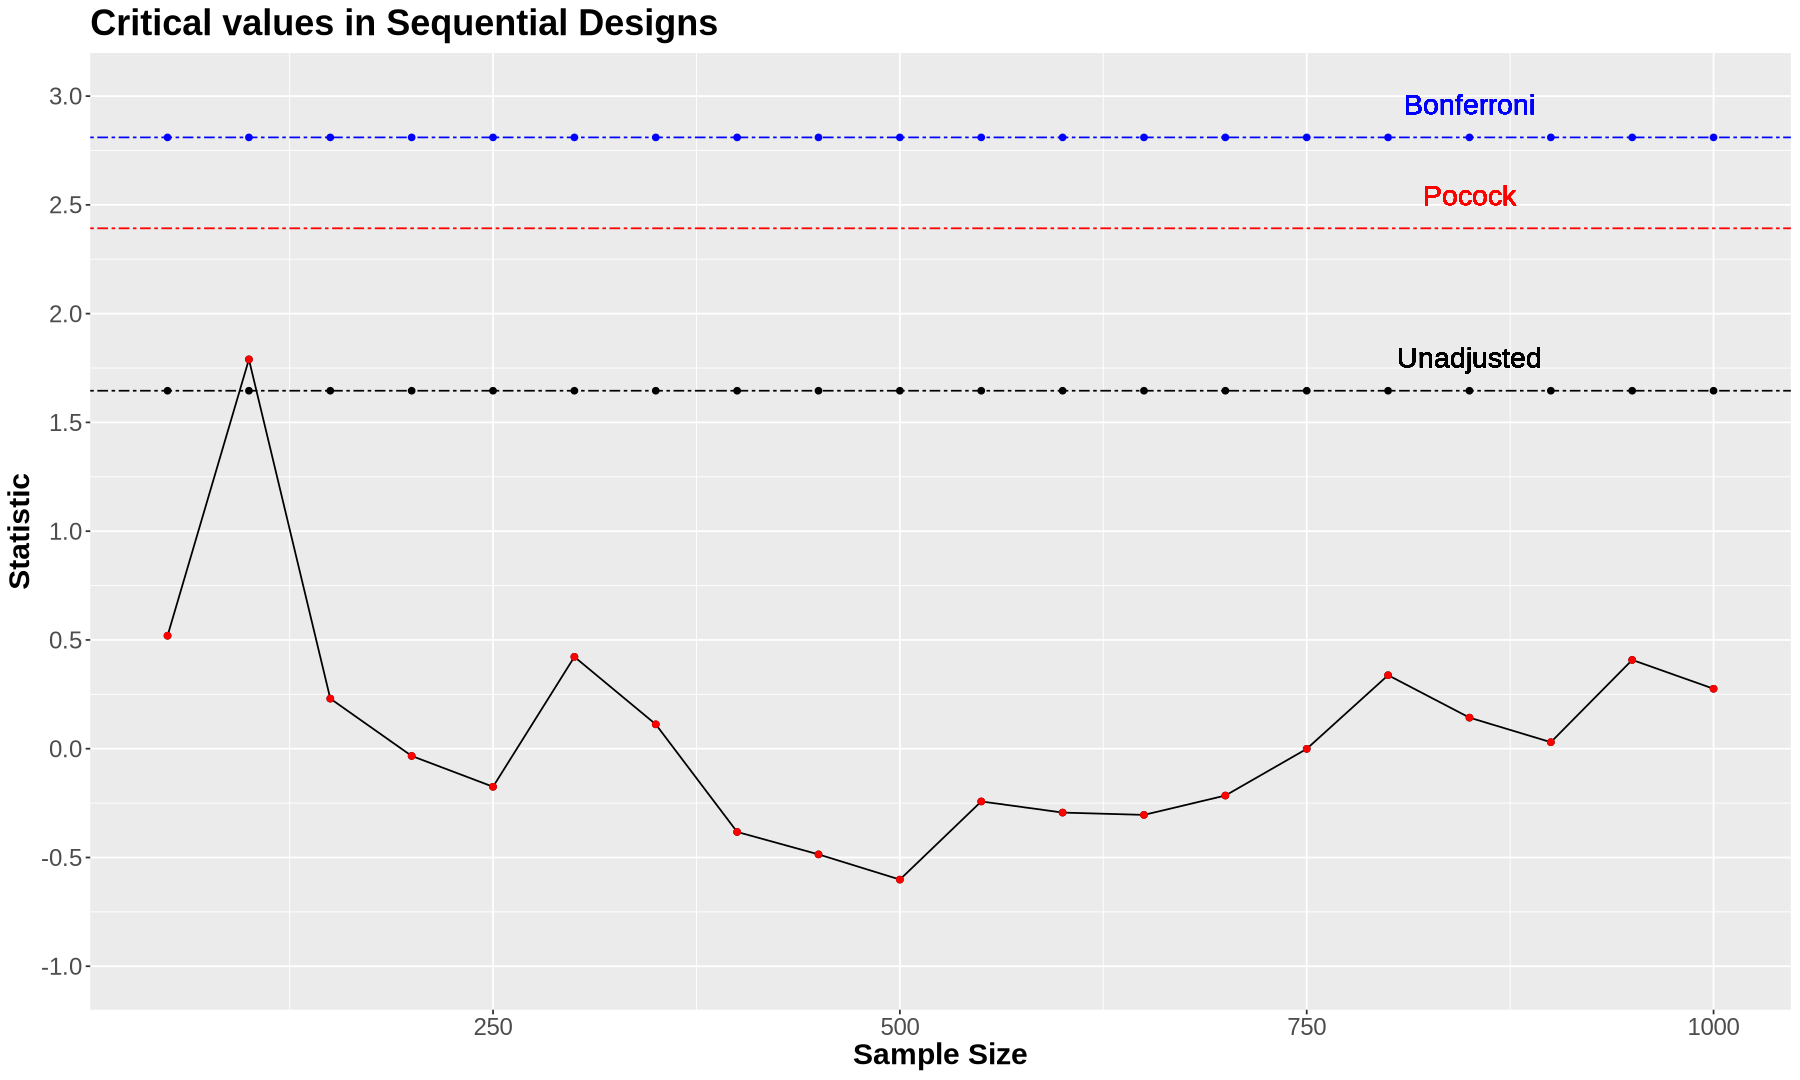

In [47]:
options(repr.plot.width = 15, repr.plot.height = 9) # Adjust these numbers so the plot looks good in your desktop.

crit_unadj <- qt(1 - 0.05, 1998)
crit_bonferroni <- qt(1 - 0.0025, 1998)

sequential_stat <- 
  answer2.1 %>%
  ggplot() +
  geom_line(aes(x = inc_sample_size, y = statistic)) +
  geom_point(aes(x = inc_sample_size, y = statistic)) +
  geom_hline(yintercept =crit_pocock, colour = "red", linetype = "twodash") +
  geom_point(aes(x = inc_sample_size, y = statistic), colour = "red") +
  geom_text(x=850, y=crit_pocock + 0.15, size=6, label="Pocock",colour = "red") +
  geom_hline(yintercept = crit_bonferroni, colour = "blue", linetype = "twodash") +
  geom_point(aes(x = inc_sample_size, y = rep(crit_bonferroni, 20)), colour = "blue") +
  geom_text(x=850, y=crit_bonferroni + 0.15, size=6, label="Bonferroni",colour = "blue") +
  geom_hline(yintercept = crit_unadj, linetype = "twodash") +
  geom_point(aes(x = inc_sample_size, y = rep(crit_unadj, 20))) +
  geom_text(x=850, y=crit_unadj + 0.15, size=6, label="Unadjusted") +
  theme(
    text = element_text(size = 18),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Critical values in Sequential Designs") +
  ylab("Statistic") +
  xlab("Sample Size") +
  coord_cartesian(ylim = c(-1, 3)) +
  scale_y_continuous(breaks = seq(-1, 3, by = 0.5))

# your code here
 # No Answer - remove if you provide an answer

sequential_stat

In [48]:
test_3.2.1()

Test passed 🎉
Test passed 🌈
Test passed 😸
Test passed 🎉
Test passed 🎉
Test passed 🥇
Test passed 😀
Test passed 😀
[1] "Success!"


**Question 3.2.2**
<br>{points: 1}

The compaign organizers have decided to monitor the data every 50 visitors per website and stop the experiment earlier if there's evidence of a difference between the group means. According to the data plotted **Question 3.2.1**, which of the following statement is correct?? 

**A.** The compaign organizers would never stop the experiment, regardless of the boundary used

**B.** The compaign organizers would erroneously stop the experiment after the analysis of the second test, regardless of the boundary used

**C.** The compaign organizers would erroneously stop the experiment after the analysis of the second test, only if they correct the critical values using a Bonferroni's method to control the type I error rate

**D.** The compaign organizers would erroneously stop the experiment after the analysis of the second test if they use undadjusted $t$ critical values 

*Assign your answer to an object called `answer3.2.2`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes.*

In [49]:
 answer3.2.2 <- "D"

# your code here
 # No Answer - remove if you provide an answer

In [50]:
test_3.2.2()

Test passed 🌈
Test passed 😀
Test passed 🥇
[1] "Success!"


**Question 3.2.3**
<br>{points: 1}

In **Question 2.1** you performed 20 interim analyses of simulated data for an A/A design. Modify the code of **Question 2.5** to implement a sequential analyses using Pocock's boundary to control the type I error in 100 experiments.

Then compare the estimated type I error rate when the Pocock's method is used with the expected type I error rate value.

*Assign your answer to an object called `answer3.2.3`. Your answer should be a tibble with two columns: `n_rejections_Pocock` and `expected_n_rejections`.*

In [51]:
answer3.2.3 <- multiple_times_sequential_tests %>% 
    mutate(reject = map_dbl(.x = seq_test, .f = function(x) sum(x$statistic>crit_pocock) > 0)) %>% 
    summarise(n_rejections_Pocock = sum(reject),
              expected_n_rejections = 5)

# your code here
# No Answer - remove if you provide an answer
                            
answer3.2.3 

n_rejections_Pocock,expected_n_rejections
<dbl>,<dbl>
7,5


In [52]:
test_3.2.3()

Test passed 🌈
Test passed 😸
Test passed 🎉
Test passed 😸
Test passed 🎊
[1] "Success!"


#### <font color=blue> Using the Pocock's method, the data can be sequentially analyzed and the experiment can be stopped earlier while controlling the type I error rate. </font>
- For the simulated experiments in the example above, the type I error rate was 7%, which close to the planned 5% value

- As expected, this method is less conservative than the Bonferroni's correction

In Tutorial 2, you will implement another sequential test method available in `gsDesign` package, called the **O’Brien-Fleming method**, which has conservative critical values for earlier interim analysis and less conservative values (closer to the unadjusted critical values) as more data are collected. In other words, bounds are not uniform. 

There are many other methods to implement principled peeking strategies in A/B testing. 
- A very popular and flexible method, implemented by [Optimizely](https://www.optimizely.com), computes a mixture sequential probability ratio test (mSPRT) tests and *always valid* $p$-values. The metholology and implementation are beyond the scope of this course but here's a nice [video](https://www.youtube.com/watch?v=AJX4W3MwKzU) that explains its key points without too many technical details.

## 4. Summary and key concepts learned

1. A/B testing refers to an experiment, in which users are randomly assigned to one of two variations of a product or service: control (A) and variation (B) to see if variation B should be used for improvement.


2. The statistic used to test a hypothesis, the sample size calculation, the type I error rate specification and the desired power are all important and interconnected pieces of the experimental design! 


3. In classical hypothesis testing theory, the sample size must be fixed in advance when the experiment is designed!!


4. Modern platforms allow the users to continuously monitor the p-values and confidence intervals of their tests as data are collected (peeking) in order to re-adjust their experiment dynamically. 


5. In particular, users would like to stop their experiments earlier depending on the results of interim analyses


6. Naively stopping experiments earlier than planned will increase the probability of *incorrectly* rejecting the null hypothesis (i.e., when there is no real effect). Stops must be part of the experimental design and appropriate testing methods must be used!


7. Sequential testing triggers a multiple comparison problem. If you make lots of comparisons, but don’t correct for it, error rates are inflated!! A particular characteristic in this setting is that tests are nested and not independent.


8. A possible way to control the type I error rated is to use a Bonferroni adjustment of the $p$-values (or equivalently the significance level or critical values). As with other multiple comparison problems, the Bonferroni's correction in sequential analysis is very conservative and can affect the power of the test!!


9. The Pocock's method offers a less conservative way of controlling the type I error rate in sequential testing with early stops.


10. *Principled* peeking is ok and even beneficial in A/B testing.

> The experimental designt is a very important piece of any statistical analysis! 